In [23]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import pymaster as nmt
import scipy.sparse as sparse
from write_covariance import remove_nans

In [24]:
pure_B = sparse.load_npz('pure_B_500.npz')

In [25]:
# e = sparse.linalg.eigsh(pure_B, 10, which='LM', return_eigenvectors=False)
# e

In [26]:
nside = 128
npix = hp.nside2npix(nside)
lmax = 3*nside-1
mask = hp.read_map('./toast_maps/0/lcdm_telescope_all_time_all_invnpp.fits',verbose=False, dtype=np.float64)
mask[np.where(mask!=0)] = 1
mask_apo = nmt.mask_apodization(mask, 5, apotype='C1')

# in_map = mask_apo*hp.read_map(f'./pure_maps/E/E_map_1.fits', field=[1,2], verbose=False, dtype=np.float64)
fsky = len(np.where(mask==1)[0])/len(mask)

/scratch/yuyang/conda/envs/toast/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(


In [27]:
in_map = mask_apo*hp.read_map('./input_maps/map_0.fits', field=[1,2], verbose=False, dtype=np.float64)

/scratch/yuyang/conda/envs/toast/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/scratch/yuyang/conda/envs/toast/lib/python3.8/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/scratch/yuyang/conda/envs/toast/lib/python3.8/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, 

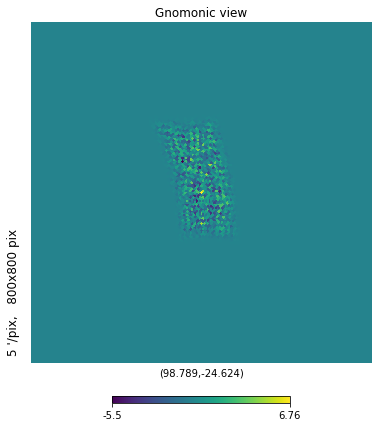

In [28]:
m_vector = np.concatenate(in_map)
remove_nans(m_vector)
m = m_vector[:npix]
#phi = 0
#m = mask*(np.cos(2*phi)*in_map[0] + np.sin(2*phi)*in_map[1])
lon,lat = hp.pix2ang(nside, np.argmax(m), lonlat=True)
lon+=0
lat+=0
hp.gnomview(m_vector[:npix], rot=(lon, lat), xsize=800, reso=5)
#hp.gnomview(m_vector[npix:], rot=(lon, lat), xsize=800, reso=5)

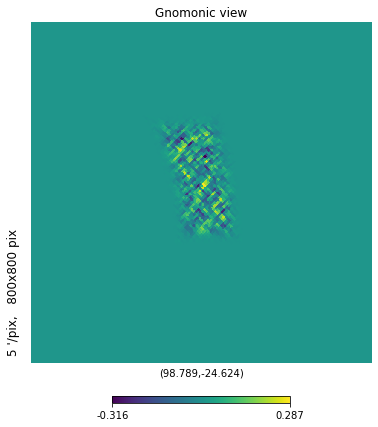

In [29]:
m_pure = pure_B.dot(m_vector)
m_pure = m_pure.reshape(2, npix)
hp.gnomview(m_pure[0], rot=(lon, lat), xsize=800, reso=5)
#hp.gnomview(m_pure[1], rot=(lon, lat), xsize=800, reso=5)

In [30]:
cl_pure = hp.anafast([np.zeros(npix), m_pure[0], m_pure[1]])
cl_regular = hp.anafast([np.zeros(npix), m_vector[:npix], m_vector[npix:]])

In [31]:
ell_th, TT, EE, BB, TE = np.loadtxt('test_dls.txt', unpack=True)
ell = ell_th[:lmax+1]
pref = ell*(ell+1)/2/np.pi

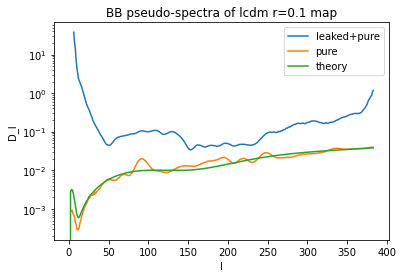

In [56]:
plt.plot(pref*cl_regular[2]*apo_transfer_smooth, label='leaked+pure')
plt.plot(pref*cl_pure[2]*apo_transfer, label='pure')
plt.plot(ell_th[:lmax+1], BB[:lmax+1], label='theory')
#plt.xscale('log')
plt.yscale('log')
plt.xlabel('l')
plt.ylabel('D_l')
plt.title('BB pseudo-spectra of lcdm r=0.1 map')
plt.legend()

In [20]:
# #estimate transfer function
# nreal = 100

# apo_transfer = np.zeros(lmax+1)

# for i in range(nreal):
#     m = hp.read_map(f'./input_maps/map_{i}.fits', field=[1,2], verbose=False, dtype=np.float64)
#     #m = hp.read_map(f'./toast_maps/{i}/lcdm_telescope_all_time_all_binned.fits', field=[1,2], verbose=False, dtype=np.float64)
#     m_apo = pure_B.dot(np.concatenate(mask_apo * m)).reshape(2, npix)
#    #m_reg = pure_B.dot(np.concatenate(mask * m)).reshape(2, npix)
#     m_reg = m

#     pcl_apo = hp.anafast([np.zeros_like(m[0]), m_apo[0], m_apo[1]])[2]
#     pcl_reg = hp.anafast([np.zeros_like(m[0]), m_reg[0], m_reg[1]])[2]
#     reg_apo = pcl_reg/pcl_apo
#     apo_transfer += reg_apo
    
# apo_transfer /= nreal

# np.save('apo_transfer.npy', apo_transfer)

/scratch/yuyang/conda/envs/toast/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
<ipython-input-20-3ce162c0d201>:15: RuntimeWarning: invalid value encountered in true_divide
  reg_apo = pcl_reg/pcl_apo


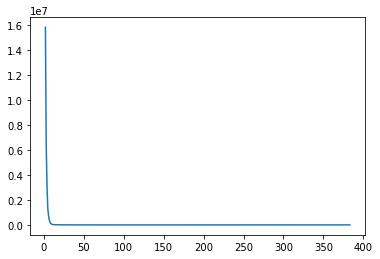

In [62]:
apo_transfer = np.load('apo_transfer.npy')
plt.plot(apo_transfer)

In [63]:
b = nmt.NmtBin.from_nside_linear(nside, 32, is_Dell=True)
ell = b.get_effective_ells()

In [65]:
ell

array([ 17.5,  49.5,  81.5, 113.5, 145.5, 177.5, 209.5, 241.5, 273.5,
       305.5, 337.5])

In [ ]:
apo_transfer.reshape(11, )

In [66]:
len(apo_transfer)

384

In [101]:
# in_map = mask*hp.read_map(f'./input_maps/map_0.fits', field=[1,2], verbose=False, dtype=np.float64)
# out_map = hp.read_map('./toast_maps/0/lcdm_telescope_all_time_all_binned.fits', field=[1,2], verbose=False, dtype=np.float64)

In [11]:
# lmax = 3*nside-1
# #ell_th, TT, EE, BB, TE = np.loadtxt('totcls_lensed_r0p1.txt', unpack=True)
# ell_th, TT, EE, BB, TE = np.loadtxt('totcls_r0.txt', unpack=True)

# total = np.array([ell_th, TT, EE, BB, TE])

# prefactor = 2*np.pi/(ell_th * (ell_th + 1))
# prefactor[0] = 0    
# cl = np.array([TT, EE, BB, TE])
# cl *= prefactor


# t,q,u = hp.synfast(cl, nside, lmax, pol=True, new=True)
# in_map = mask_apo*np.array([q, u])

In [12]:
# lmax = 3*nside-1
    

# cl_TT = np.zeros(lmax+1)
# cl_EE = np.ones(lmax+1)
# cl_BB = np.zeros(lmax+1)
# cl_TE = np.zeros(lmax+1)
        

    
# cl_TT[0] = cl_TT[1] = 0
# cl_BB[0] = cl_BB[1] = 0
# cl_EE[0] = cl_EE[1] = 0
# cl_TE[0] = cl_TE[1] = 0
    
    
# ell = np.arange(lmax+1)

# prefactor = 2*np.pi/(ell * (ell + 1))
# prefactor[0] = 0

# cl = np.array([cl_TT, cl_EE, cl_BB, cl_TE])
# cl *= prefactor


# t,q,u = hp.synfast(cl, nside, lmax, pol=True, new=True)
# in_map = mask*np.array([q, u])